In [1]:
import networkx as nx
import gzip
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import random
from IPython.display import HTML
import heapq

In [2]:
def load_facebook_graph(path):
    G = nx.Graph()
    with gzip.open(path, 'rt') as f:
        for line in f:
            u, v = map(int, line.strip().split())
            G.add_edge(u, v)
    return G


def load_ca_grqc_graph(path):
    G = nx.Graph()
    with gzip.open(path, 'rt') as f:
        for line in f:
            if line.startswith('#'):
                continue
            u, v = map(int, line.strip().split())
            G.add_edge(u, v)
    return G


In [3]:
def independent_cascade(G, seeds, p=0.01):
    steps = []
    activated = set(seeds)
    new_activated = set(seeds)
    steps.append(set(seeds))

    while new_activated:
        next_activated = set()
        for node in new_activated:
            for neighbor in G.neighbors(node):
                if neighbor not in activated:
                    if random.random() <= p:
                        next_activated.add(neighbor)
        new_activated = next_activated
        if new_activated:
            steps.append(set(new_activated))
        activated |= new_activated
    return activated, steps

In [4]:
def greedy_influence_maximization(G, k, p=0.01, simulations=10):
    seeds = []
    for _ in range(k):
        best_node = None
        best_spread = 0
        for node in G.nodes():
            if node in seeds:
                continue
            temp_seeds = seeds + [node]
            spread = 0
            for _ in range(simulations):
                activated, _ = independent_cascade(G, temp_seeds, p)
                spread += len(activated)
            avg_spread = spread / simulations
            if avg_spread > best_spread:
                best_spread = avg_spread
                best_node = node
        seeds.append(best_node)
    return seeds


In [5]:
def animate_ic_spread(G, steps, seeds, layout=None):
    if layout is None:
        layout = nx.spring_layout(G, seed=42)

    fig, ax = plt.subplots(figsize=(12, 8))
    all_activated = set()

    def update(frame):
        ax.clear()
        current = set.union(*steps[:frame+1])
        new_nodes = steps[frame] if frame < len(steps) else set()
        
        colors = []
        for node in G.nodes():
            if node in seeds:
                colors.append('red')
            elif node in new_nodes:
                colors.append('orange')
            elif node in current:
                colors.append('yellow')
            else:
                colors.append('lightgray')

        nx.draw(
            G, pos=layout,
            node_color=colors,
            with_labels=False,
            node_size=20,
            edge_color='gray',
            alpha=0.6,
            ax=ax
        )
        ax.set_title(f"Independent Cascade - Step {frame}")

    ani = animation.FuncAnimation(
        fig, update, frames=len(steps), interval=800, repeat=False
    )
    plt.close(fig)
    return ani


In [6]:
G = load_facebook_graph('facebook_combined.txt.gz')
print(f"Graph loaded with {G.number_of_nodes()} nodes and {G.number_of_edges()} edges")


Graph loaded with 4039 nodes and 88234 edges


In [7]:
k = 40  # number of seeds
p = 0.1  # influence probability

seeds = greedy_influence_maximization(G, k=k, p=p, simulations=3)
print("Selected seed nodes:", seeds)


Selected seed nodes: [1875, 777, 2132, 1333, 1581, 2709, 2101, 2169, 2737, 4003, 2033, 3924, 34, 1461, 1431, 175, 3345, 1385, 1157, 3207, 1575, 2177, 462, 3853, 1466, 194, 3877, 157, 3459, 1816, 3514, 132, 2274, 2604, 2551, 3104, 1803, 2417, 2058, 645]


In [ ]:
_, steps = independent_cascade(G, seeds, p=p)

layout = nx.spring_layout(G, seed=42)
ani = animate_ic_spread(G, steps, seeds, layout)

display(HTML(ani.to_jshtml()))


In [ ]:
G = load_ca_grqc_graph('ca-GrQc.txt.gz')
print(f"Graph has {G.number_of_nodes()} nodes and {G.number_of_edges()} edges")

Graph has 5242 nodes and 14496 edges


In [ ]:
k = 50  # number of seeds
p = 0.2  # influence probability

seeds = greedy_influence_maximization(G, k=k, p=p, simulations=3)
print("Selected seed nodes:", seeds)

Selected seed nodes: [392, 12496, 25661, 16717, 5402, 8395, 1051, 2295, 14933, 11328, 3766, 13740, 18282, 7013, 19741, 13683, 24726, 21157, 18667, 9392, 18161, 5698, 19252, 24334, 18970, 11502, 10517, 19463, 16565, 1407, 18445, 18720, 24587, 18444, 10878, 179, 24474, 15423, 15917, 2287, 3449, 11566, 24, 2304, 1280, 18042, 25844, 844, 15198, 18160]


In [ ]:
_, steps = independent_cascade(G, seeds, p=p)

layout = nx.spring_layout(G, seed=42)
ani = animate_ic_spread(G, steps, seeds, layout)

display(HTML(ani.to_jshtml()))


In [6]:

def celfpp(G, k, p=0.01, simulations=5):
    seeds = []
    queue = []

    # Initial marginal gain (no seed set)
    for node in G.nodes():
        total_spread = 0
        for _ in range(simulations):
            activated, _ = independent_cascade(G, [node], p)
            total_spread += len(activated)
        avg_spread = total_spread / simulations
        heapq.heappush(queue, (-avg_spread, node, 0))  # (gain, node, last_updated_round)

    round = 0
    while len(seeds) < k:
        while True:
            gain, node, last_update = heapq.heappop(queue)
            gain = -gain

            if last_update == round:
                seeds.append(node)
                round += 1
                break
            else:
                gain_with = 0
                gain_without = 0
                for _ in range(simulations):
                    activated, _ = independent_cascade(G, seeds + [node], p)
                    spread_with = len(activated)
                    activated, _ = independent_cascade(G, seeds, p)
                    spread_wo = len(activated)
                    gain_with += spread_with
                    gain_without += spread_wo
                marginal_gain = (gain_with - gain_without) / simulations
                heapq.heappush(queue, (-marginal_gain, node, round))

    return seeds


In [7]:

import random

def generate_rr_set(G, p):
    target_node = random.choice(list(G.nodes()))
    rr_set = {target_node}
    queue = [target_node]
    while queue:
        current = queue.pop()
        for predecessor in G.predecessors(current) if G.is_directed() else G.neighbors(current):
            if predecessor not in rr_set and random.random() <= p:
                rr_set.add(predecessor)
                queue.append(predecessor)
    return rr_set


def imm(G, k, p=0.01, R=1000):
    rr_sets = [generate_rr_set(G, p) for _ in range(R)]

    node_coverage = {}
    for i, rr in enumerate(rr_sets):
        for node in rr:
            node_coverage.setdefault(node, set()).add(i)

    seeds = []
    covered = set()
    for _ in range(k):
        best_node = max(
            ((node, sets) for node, sets in node_coverage.items() if node not in seeds),
            key=lambda x: len(x[1] - covered)
        )[0]
        seeds.append(best_node)
        covered |= node_coverage[best_node]

    return seeds


In [8]:
import numpy as np
import time

def evaluate_seed_strategy(G, strategy_fn, strategy_name, k=5, p=0.01, simulations=10, **kwargs):
    start_time = time.time()
    
    # Select seed nodes
    seeds = (
        strategy_fn(G, k=k, p=p, simulations=simulations, **kwargs)
        if strategy_name != 'IMM'
        else strategy_fn(G, k=k, p=p, R=1000)
    )
    selection_time = time.time() - start_time

    # Simulate influence spread
    spreads = []
    for _ in range(simulations):
        activated, _ = independent_cascade(G, seeds, p)
        spreads.append(len(activated))

    avg_cov = np.mean(spreads)
    max_cov = np.max(spreads)

    avg_time = selection_time / simulations

    print(f"{strategy_name}:")
    print(f"  Seed nodes: {seeds}")
    print(f"  Time to select seeds: {avg_time:.2f} seconds")
    print(f"  Average spread: {avg_cov:.2f} nodes")
    print(f"  Best spread: {max_cov} nodes")

    return seeds, avg_time, avg_cov, max_cov


Graph loaded with 4039 nodes and 88234 edges
Greedy:
  Seed nodes: [363, 705, 3730, 1765, 692, 3914, 3806, 2067, 1096, 1764, 3129, 2703, 249, 189, 3099, 986, 1271, 3930, 3980, 1130, 119, 552, 3880, 1891, 1420, 3043, 274, 3397, 3950, 3911, 42, 4029, 3302, 756, 1310, 982, 965, 3874, 827, 940]
  Time to select seeds: 1679.92 seconds
  Average spread: 3069.60 nodes
  Best spread: 3129 nodes
CELF++:
  Seed nodes: [2945, 3731, 747, 55, 904, 2628, 328, 1408, 767, 265, 1045, 1786, 3717, 3781, 3269, 20, 711, 3087, 2600, 670, 3980, 2643, 2823, 3999, 972, 1253, 689, 1258, 92, 207, 3378, 926, 3280, 2047, 222, 4013, 3562, 3982, 2560, 137]
  Time to select seeds: 144.62 seconds
  Average spread: 3085.56 nodes
  Best spread: 3157 nodes
IMM:
  Seed nodes: [107, 686, 3927, 66, 64, 181, 35, 97, 1776, 2982, 3235, 3481, 3888, 41, 837, 155, 735, 790, 1992, 91, 3566, 1252, 776, 228, 259, 1270, 3980, 130, 178, 193, 219, 351, 383, 425, 437, 549, 568, 590, 626, 677]
  Time to select seeds: 0.14 seconds
  Avera

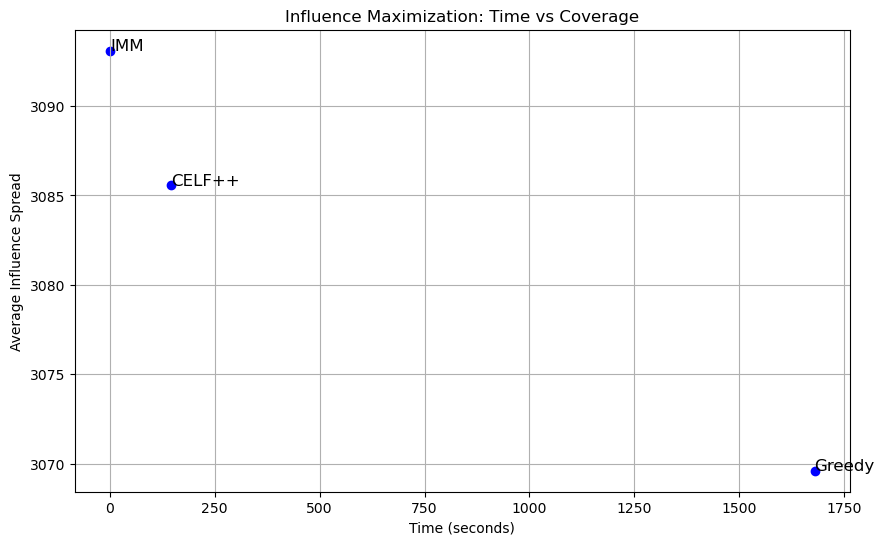

In [9]:
G = load_facebook_graph('facebook_combined.txt.gz')
print(f"Graph loaded with {G.number_of_nodes()} nodes and {G.number_of_edges()} edges")

k=40
p=0.1
simulations=50

# Collect evaluation results
results = []
results.append(evaluate_seed_strategy(G, greedy_influence_maximization, 'Greedy', k=k, p=p, simulations=5))
results.append(evaluate_seed_strategy(G, celfpp, 'CELF++', k=k, p=p, simulations=simulations))
results.append(evaluate_seed_strategy(G, imm, 'IMM', k=k, p=p, simulations=simulations))

# Unpack results
names = ['Greedy', 'CELF++', 'IMM']
times = [r[1] for r in results]
avg_coverage = [r[2] for r in results]
max_coverage = [r[3] for r in results]

# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(times, avg_coverage, color='blue')
for i, name in enumerate(names):
    plt.text(times[i] + 0.1, avg_coverage[i], name, fontsize=12)

plt.title("Influence Maximization: Time vs Coverage")
plt.xlabel("Time (seconds)")
plt.ylabel("Average Influence Spread")
plt.grid(True)
plt.show()



Graph has 5242 nodes and 14496 edges
Greedy:
  Seed nodes: [9639, 22421, 18370, 6030, 23092, 2455, 2980, 14385, 16234, 6354, 18094, 2621, 6667, 11447, 7636, 21949, 142, 4634, 14485, 5083, 21635, 5511, 12263, 20250, 22462, 16230, 16881, 10463, 1014, 11964, 13621, 12491, 3845, 5232, 6218, 23266, 13318, 19495, 321, 21029, 13705, 8305, 2124, 8048, 3683, 5769, 10056, 5960, 7007, 17192]
  Time to select seeds: 337.44 seconds
  Average spread: 1274.80 nodes
  Best spread: 1341 nodes
CELF++:
  Seed nodes: [14540, 15999, 17600, 19048, 25540, 15145, 14340, 18880, 21391, 3547, 299, 15571, 5136, 15938, 5056, 7504, 23064, 5838, 23559, 15206, 26021, 7592, 5631, 19871, 12806, 17245, 4656, 21635, 13144, 22502, 24885, 11199, 25272, 18791, 21156, 5570, 834, 20243, 1093, 15814, 22806, 12587, 25729, 21152, 7042, 10354, 18973, 14430, 3752, 3193]
  Time to select seeds: 12.91 seconds
  Average spread: 1359.88 nodes
  Best spread: 1502 nodes
IMM:
  Seed nodes: [6179, 6583, 18444, 18743, 13190, 16754, 930, 24

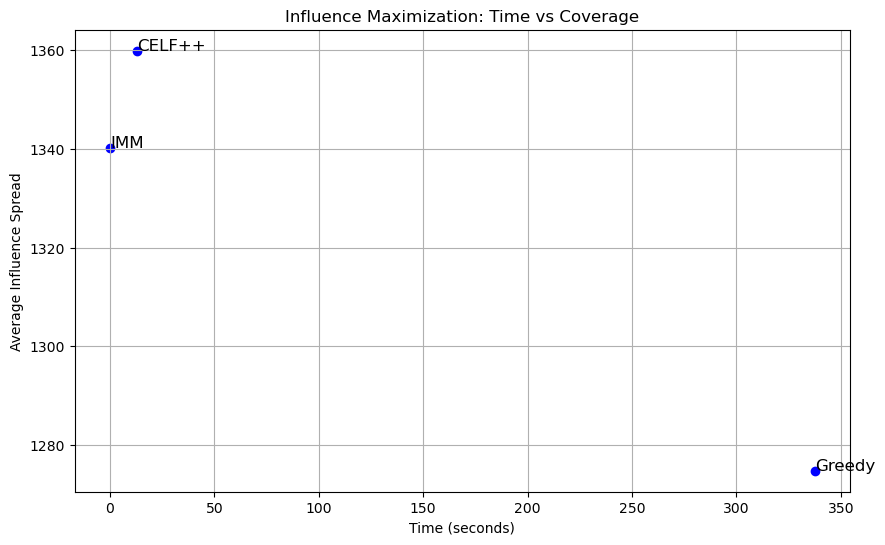

In [10]:
G = load_ca_grqc_graph('ca-GrQc.txt.gz')
print(f"Graph has {G.number_of_nodes()} nodes and {G.number_of_edges()} edges")

k=50
p=0.2
simulations=50

# Collect evaluation results
results = []
results.append(evaluate_seed_strategy(G, greedy_influence_maximization, 'Greedy', k=k, p=p, simulations=5))
results.append(evaluate_seed_strategy(G, celfpp, 'CELF++', k=k, p=p, simulations=simulations))
results.append(evaluate_seed_strategy(G, imm, 'IMM', k=k, p=p, simulations=simulations))

# Unpack results
names = ['Greedy', 'CELF++', 'IMM']
times = [r[1] for r in results]
coverage = [r[2] for r in results]

# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(times, coverage, color='blue')
for i, name in enumerate(names):
    plt.text(times[i] + 0.1, coverage[i], name, fontsize=12)

plt.title("Influence Maximization: Time vs Coverage")
plt.xlabel("Time (seconds)")
plt.ylabel("Average Influence Spread")
plt.grid(True)
plt.show()
